# Introduction

This notebook contains the empirical comparison of the different portfolio models. The portfolios are deployed on the same data and their cumulative returns are compared using plots.

# Import modules

In [1]:
import sys
from unipath import Path

# append codelib to sys path ~ will only work if this jupyter notebook path is sys.path[0]
p = Path(sys.path[0])
codelib_path = str(p.parent + Path('\\codelib'))
sys.path.insert(0, codelib_path)

# import codelib
from helpers import *
from mean_variance_markowitz import *

# other modules
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import time
import datetime

# Import data

The data used here is from the Kenneth-French database ([KF database](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)). The portfolios can be either equal weighted or value weighted. The portfolios are industry portfolios, thus the assets may be interpreted as ETFs on industries.

In [2]:
# setting dates
start = "1900-01-01"
end   = "2022-01-01"
port  = "49_Industry_Portfolios"

# pulling data
df = pdr.famafrench.FamaFrenchReader(port, start, end).read()[0] # 0 = value weighted, 1 = equal weighted
df = df.replace(-99.99,0) # replace nan values
df = df / 100 # changing format to decimals

# dates
if port[-1] == "s":
    dates = df.index.to_timestamp()
else:
    dates = df.index

# returns in array
ret = df.to_numpy()

# Performance of portfolios

The input for the closed form portfolio optimization models will all have a series of returns as input. The series of returns will result in a vector of expected returns with length of number of assets and a covariance matrix.

**Input for models**

$$
\text{ret} = 
\begin{bmatrix} 
r_{t0}^1 & r_{t0}^2 & \dots & r_{t0}^N \\ 
r_{t1}^1 & r_{t1}^2 & \dots & r_{t1}^N \\ 
\vdots & \vdots & \ddots &  \vdots \\ 
r_{T}^1 & r_{T}^2 & \dots & r_{T}^N \\ 
\end{bmatrix}
$$


## Equal weighted portfolio

In [3]:
base_window = int(0.5 * len(ret))
number_windows = len(ret) - base_window

# storing returns
eq_realized = np.empty([number_windows])
eq_expected = np.empty([number_windows])

for window in range(base_window, len(ret)):
    
    # equal weighted portfolio
    eq_ret_instance = equal_weighted_portfolio(ret[window])
    
    # storing returns
    idx = window - number_windows
    eq_realized[idx] = eq_ret_instance

## Mean-Variance optimization

The process of calculating the MV expected and realized returns are conducted as follows.

1. Define initial window of asset returns.
2. Calculate $\mu$ and $\Sigma$ from the window of returns.
3. Calculate expected returns of mean-variance portfolio with current window of returns.
4. Calculate realized returns of mean-vairnace portfolio with next period returns.
5. Increase window with next month and repeat (2 - 4) ~ the window grows until it equal full time horizon.

In [4]:
base_window = int(0.50 * len(ret))
number_windows = len(ret) - base_window

# storing returns
mv_realized = np.empty([number_windows])
mv_expected = np.empty([number_windows])

for window in range(base_window, len(ret)):
    
    # the current instance of returns
    ret_instance = ret[0:window]
    
    # input returns
    mu_instance = np.mean(ret_instance, axis=0)
    
    # tangency portfolio
    tan_weights = tangency_portfolio_weights(mu_instance, ret_instance, 0, False)
    tan_ret = tangency_portfolio_return(mu_instance, ret_instance, 0, False)
    realized_tan_ret = ret[window] * tan_weights
    
    # storing returns
    idx = window - number_windows
    mv_expected[idx] = tan_ret
    mv_realized[idx] = np.sum(realized_tan_ret)

## Mean-Variance optimization w. Ledoit-Wolf covariance shrinkage

The process of calculating the ledoit-wolf expected and realized returns are similar to the mean-variance.

1. Define initial window of asset returns.
2. Calculate $\mu$ and $\Sigma_\nu$ from the window of returns.
3. Calculate expected returns of ledoit-wolf portfolio with current window of returns.
4. Calculate realized returns of ledoit-wolf portfolio with next period returns.
5. Increase window with next month and repeat (2 - 4) ~ the window grows until it equal full time horizon.

Where $\Sigma_\nu$ is the Ledoit Wolf covariance matrix.

In [5]:
base_window = int(0.50 * len(ret))
number_windows = len(ret) - base_window

mv_realized_ledoit = np.empty([number_windows])
mv_expected_ledoit = np.empty([number_windows])

for window in range(base_window, len(ret)):
    
    # the current instance of returns
    ret_instance = ret[0:window]
    
    # input returns
    mu_instance = np.mean(ret_instance, axis=0)
    
    # tangency portfolio ledoit
    tan_weights_ledoit = tangency_portfolio_weights(mu_instance, ret_instance, 0, True)
    ret_ledoit = tangency_portfolio_return(mu_instance, ret_instance, 0, True)
    realized_ledoit = ret[window] * tan_weights_ledoit
    
    idx = window - number_windows
    mv_realized_ledoit[idx] = np.sum(realized_ledoit)
    mv_expected_ledoit[idx] = ret_ledoit

# Plotting portfolio returns

Below are two plots. The first one displays the cumulative realized returns of the portfolios. The second displays the cumulative expected returns of the portfolios. 

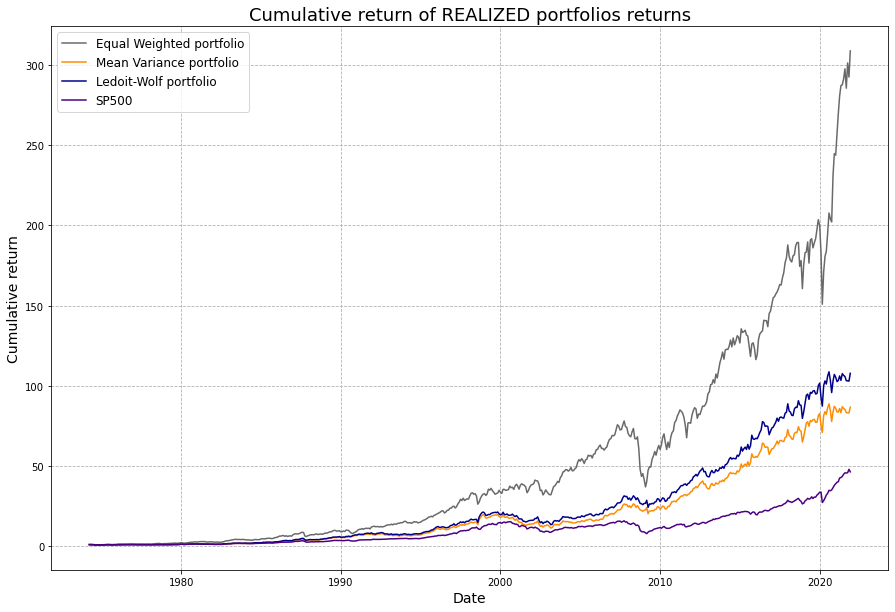

In [6]:
plt.figure(figsize=(15,10))

date_axis = dates[base_window:]

# sp500 returns
sp_ret = sp500_monthly_returns(dates[base_window-1], date_axis[-1])

# plotting cumulative returns
plt.plot(date_axis, (1+eq_realized).cumprod(), color="dimgrey", label="Equal Weighted portfolio")
plt.plot(date_axis, (1+mv_realized).cumprod(), color="darkorange", label="Mean Variance portfolio")
plt.plot(date_axis, (1+mv_realized_ledoit).cumprod(), color="darkblue", label="Ledoit-Wolf portfolio")
plt.plot(date_axis, (1+sp_ret).cumprod(), color="indigo", label="SP500")

plt.ylabel("Cumulative return", size=14)
plt.xlabel("Date", size=14)
plt.title("Cumulative return of REALIZED portfolios returns", size=18)

plt.grid(linestyle="--")
plt.legend(prop={'size': 12})

plt.show()

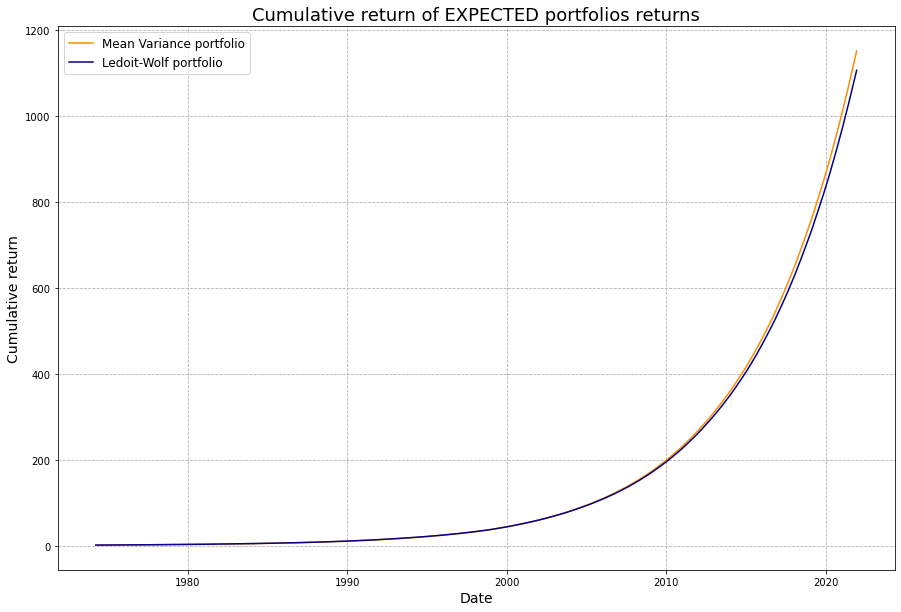

In [7]:
plt.figure(figsize=(15,10))

date_axis = dates[base_window:]

plt.plot(date_axis, (1+mv_expected).cumprod(), color="darkorange", label="Mean Variance portfolio")
plt.plot(date_axis, (1+mv_expected_ledoit).cumprod(), color="darkblue", label="Ledoit-Wolf portfolio")

plt.ylabel("Cumulative return", size=14)
plt.xlabel("Date", size=14)
plt.title("Cumulative return of EXPECTED portfolios returns", size=18)

plt.grid(linestyle="--")
plt.legend(prop={'size': 12})

plt.show()